In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import process 


2024-12-09 14:35:30.448911: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 14:35:30.464982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733776530.482358 1839728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733776530.487596 1839728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 14:35:30.506995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Nibabel

In [99]:
import nibabel as nib
import os
import glob

import process 


ppdata_path = '/media/large_ssd/ab126/OpenNeuro/ppdata'
paths = os.listdir(ppdata_path)

nifti_rel_path = '/func1pt8mm/timeseries'
nifti_path = ppdata_path + '/subj03' +  nifti_rel_path
for pth in glob.glob(nifti_path + '/*'):
    img_file = nib.load(pth)
    #img_file = process.load_nifti(pth)
    print(img_file.shape)
    tmp = pth

(226, 106, 81, 82)
(226, 106, 81, 82)
(226, 106, 81, 82)
(226, 106, 81, 82)
(226, 106, 81, 82)
(226, 106, 81, 82)


KeyboardInterrupt: 

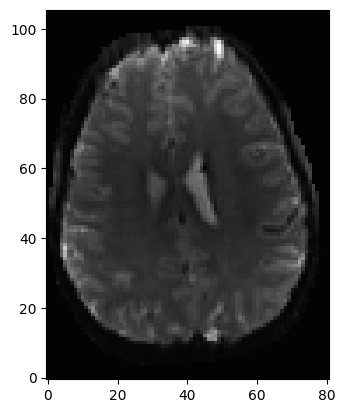

In [100]:
import matplotlib.pyplot as plt


f_img_data = img_file.get_fdata()
plt.imshow(f_img_data[:,:, 53, 0].T, cmap='gray', origin='lower') # Transposing gives MNI coord system

In [98]:
f_img_data.dtype, f_img_data.shape

(dtype('float64'), (81, 106, 82, 226))

# Load Data

In [40]:
import process

import importlib
importlib.reload(process)

<module 'process' from '/home/ab126/PycharmProjects/ELEC-576/Project/process.py'>

In [41]:
from process import NSDDataset

ppdata_path = '/media/large_ssd/ab126/OpenNeuro/ppdata'
data_handler = NSDDataset(ppdata_path)

In [42]:
data_handler.precompute_nifti2numpy(only_indices=True)

1st pass 

Subject subj04
timeseries_session02_run02.nii.gz
Done

Subject subj01
Done

Subject subj02
Done

Subject subj05
Done

Subject subj03
Done


In [45]:
data_handler.__len__()

54648

In [31]:
data_handler.precompute_nifti2numpy()

1st pass 

Subject subj04
timeseries_session02_run02.nii.gz
Done

Subject subj01
Done

Subject subj02
Done

Subject subj05
Done

Subject subj03
Done

2nd pass 

Subject subj04
Done

Subject subj01
Done

Subject subj02
Done

Subject subj05
Done

Subject subj03
Done


In [10]:
def_size = (226, 96, 84, 80, 1)
for batch, lbl in data_handler:
    print(batch.shape)
    if def_size != batch.shape:
        break

(226, 96, 84, 80, 1)


In [116]:
batch.shape

(226, 96, 84, 80, 1)

# Model

In [32]:
import process

import importlib
importlib.reload(process)

<module 'process' from '/home/ab126/PycharmProjects/ELEC-576/Project/process.py'>

In [46]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv3D, Conv3DTranspose, BatchNormalization, MaxPooling3D, UpSampling3D, Flatten, Activation
from keras import losses

# Encoder
encoder = Sequential()
encoder.add(Input(shape=( 96, 84, 80, 1)))

encoder.add(Conv3D(32, kernel_size=(5, 5, 5), padding="same"))
#encoder.add(BatchNormalization())
encoder.add(Activation('relu'))

encoder.add(MaxPooling3D(2))

encoder.add(Conv3D(8, kernel_size=(5, 5, 5), padding="same"))
#encoder.add(BatchNormalization())
encoder.add(Activation('relu'))

encoder.add(MaxPooling3D(2))

# Dense Layers
"""
encoder.add(Flatten())

encoder.add(Dense(1024))
encoder.add(Activation('relu'))

encoder.add(Dense(16))
encoder.add(Activation('relu'))
"""

# Decoder
decoder = Sequential()

# Reshape

# Dense layers 
""" """

decoder.add(Conv3DTranspose(8, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('relu'))

decoder.add(UpSampling3D(2))

decoder.add(Conv3DTranspose(32, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('relu'))

decoder.add(UpSampling3D(2))


class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#autoencoder = Autoencoder()
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 24, 21, 20, 8)  │        36,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 96, 84, 80, 32) │        40,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,080 (297.19 KB)

 Trainable params: 76,080 (297.19 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 96, 84, 80, 32) │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 96, 84, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 48, 42, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 48, 42, 40, 8)  │        32,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 48, 42, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 24, 21, 20, 8)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,040 (140.78 KB)

 Trainable params: 36,040 (140.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_transpose_8              │ (None, 24, 21, 20, 8)  │         8,008 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 24, 21, 20, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_8 (UpSampling3D)  │ (None, 48, 42, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_9              │ (None, 48, 42, 40, 32) │        32,032 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 48, 42, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_9 (UpSampling3D)  │ (None, 96, 84, 80, 32) │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,040 (156.41 KB)

 Trainable params: 40,040 (156.41 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
checkpoint_path = "saves/training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

history = autoencoder.fit(data_handler, epochs=10, shuffle=True, callbacks=[cp_callback])

Epoch 1/10
   46/54648 ━━━━━━━━━━━━━━━━━━━━ 1:25:31 94ms/step - loss: 49200.4492

E0000 00:00:1733794525.501928 1842874 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733794525.609907 1842874 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


54648/54648 ━━━━━━━━━━━━━━━━━━━━ 7555s 138ms/step - loss: 10823.9043
Epoch 2/10
18548/54648 ━━━━━━━━━━━━━━━━━━━━ 1:36:12 160ms/step - loss: 8978.2656

KeyboardInterrupt: 

Text(0.5, 0, 'epoch')

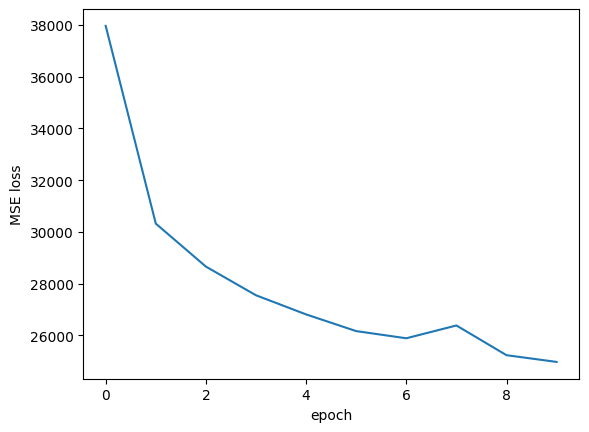

In [54]:
plt.plot(history.history['loss'])
plt.ylabel('MSE loss')
plt.xlabel('epoch')


In [60]:
# Manually save
autoencoder.save_weights(checkpoint_path)


In [63]:
model_path = "saves/autoencoder_cnn_only.keras"
autoencoder.save(model_path)

In [68]:
# Load previous models
model_path = "saves/autoencoder_cnn_only.keras"
autoencoder = tf.keras.models.load_model(model_path)

In [69]:
autoencoder.evaluate(data_handler)

   45/54648 ━━━━━━━━━━━━━━━━━━━━ 46:17 51ms/step - loss: 11969.9160

KeyboardInterrupt: 

## Interpretation

# Tuning

In [ ]:
# Use tensorboard